In [1]:
import numpy as np
import scipy as sc
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import json

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18

from sklearn.linear_model import LinearRegression

from qpfs import *

lr = LinearRegression()

In [2]:
def RMSE(y, p):
    return np.sqrt(np.mean((y - p) ** 2))

In [3]:
def plot_score(score, filename):

    plt.figure(figsize=(6, 4))
    plt.semilogy(sorted(score)[::-1])
    plt.tight_layout()
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig(filename, format='eps')
    plt.show()

In [4]:
def get_split(X, n_splits=5):
    n = X.shape[0]
    train_size = int(n / (1 + n_splits * 0.25))
    test_size = int(0.25 * train_size)
    train_idx = np.arange(train_size)
    test_idx = np.arange(train_size, min(n, train_size + test_size))
    for i in range(n_splits):
        yield train_idx, test_idx
        train_size += test_size
        train_idx = np.arange(train_size)
        test_idx = np.arange(train_size, min(n, train_size + test_size))
        

def get_train_test_rmse(n_active_array, score, Xtrain, Ytrain, Xtest, Ytest):

    train_err_array = []
    test_err_array = []
    for k in n_active_array:
        active_idxs = score.argsort()[::-1][:k]
        lr.fit(Xtrain[:, active_idxs], Ytrain)
        pred = lr.predict(Xtrain[:, active_idxs])
        train_err_array.append(RMSE(Ytrain, pred))
        pred = lr.predict(Xtest[:, active_idxs])
        test_err_array.append(RMSE(Ytest, pred))

    return train_err_array, test_err_array

In [5]:
Xtrain = sc.io.loadmat('./../data/ECoG_X_train.mat')['X_train'].reshape([-1, 32 * 27])
Ytrain = sc.io.loadmat('./../data/ECoG_Y_train.mat')['Y_train']

Xtest = sc.io.loadmat('./../data/ECoG_X_test.mat')['X_hold_out'].reshape([-1, 32 * 27])
Ytest = sc.io.loadmat('./../data/ECoG_Y_test.mat')['Y_hold_out']

n_samples, n_features = Xtrain.shape

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(12801, 864) (12801, 3)
(6087, 864) (6087, 3)


In [6]:
lr.fit(Xtrain, Ytrain)

pred = lr.predict(Xtrain)
print('train: ', RMSE(Ytrain, pred))

pred = lr.predict(Xtest)
print('test: ', RMSE(Ytest, pred))

train:  38.441522087
test:  42.2703059983


In [7]:
qpfs = QPFS()

qpfs.fit(Xtrain, Ytrain)

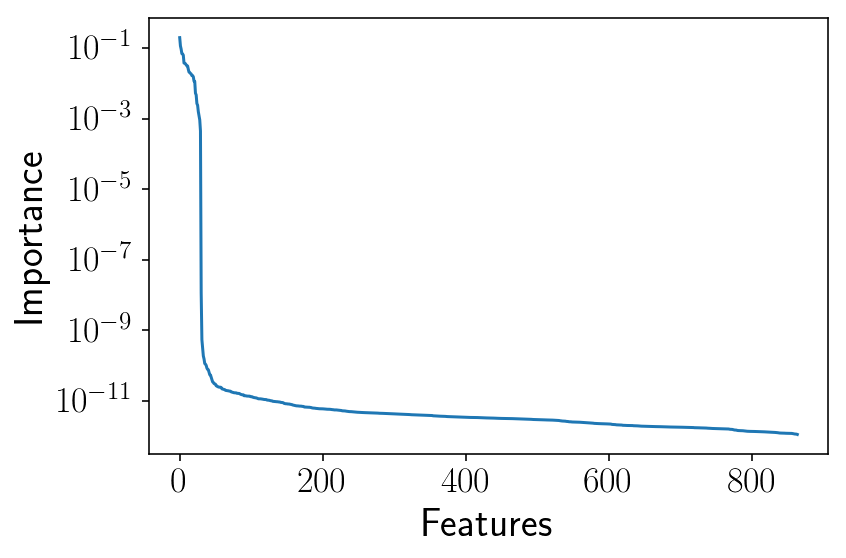

In [8]:
plot_score(qpfs.zx, 'figs2/feature_scores_ex.eps')

In [10]:
n_active_array = np.arange(1, n_features, 5)
errors = {'train': [], 'test': []}

#errors['train'], errors['test'] = get_train_test_rmse(n_active_array, qpfs.score, 
#                                    Xtrain, Ytrain, Xtest, Ytest)

#with open('res/errors_qpfs_example.json', 'w') as f:
#    f.write(json.dumps(errors))

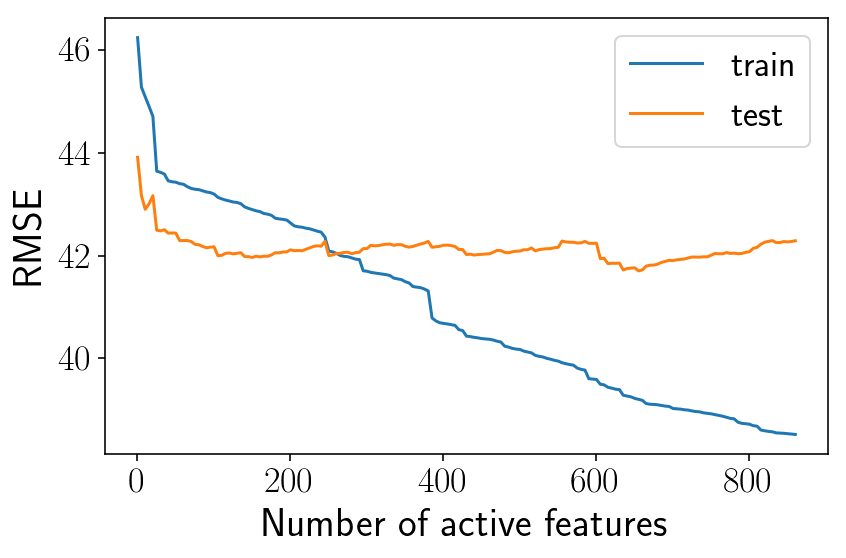

In [11]:
with open('res/errors_qpfs_example.json', 'r') as f:
    errors = json.loads(f.read())

plt.figure(figsize=(6, 4))

plt.plot(n_active_array, errors['train'], label='train')
plt.plot(n_active_array, errors['test'], label='test')
plt.xlabel('Number of active features')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.savefig('figs2/train_test_qpfs.eps', format='eps')
plt.show()

## Bootstrap

In [ ]:
from sklearn.model_selection import KFold

np.random.seed(42)
cv = KFold(n_splits=5, shuffle=True)

n_restarts = 5
n_active_array = np.arange(1, n_features, 5)
errors = {'train': [], 'test': []}

for train_idx, test_idx in tqdm_notebook(cv.split(Xtrain), total=n_restarts):
    train, test = get_train_test_rmse(n_active_array, qpfs.zx, 
                                    Xtrain[train_idx], Ytrain[train_idx], 
                                      Xtrain[test_idx], Ytrain[test_idx])
    
    errors['train'].append(train)
    errors['test'].append(test)

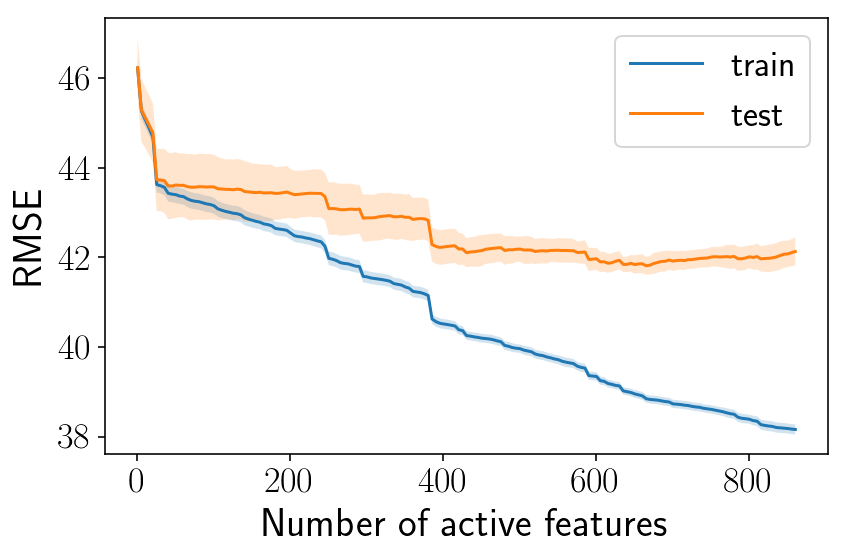

In [12]:
train_mean = np.array(errors['train']).mean(axis=0)
train_std = np.array(errors['train']).std(axis=0)
test_mean = np.array(errors['test']).mean(axis=0)
test_std = np.array(errors['test']).std(axis=0)

plt.figure(figsize=(6, 4))

plt.fill_between(n_active_array, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(n_active_array, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.plot(n_active_array, train_mean, label='train')
plt.plot(n_active_array, test_mean, label='test')
plt.xlabel('Number of active features')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.savefig('figs2/train_test_qpfs_bootstrap.pdf', format='pdf')
plt.show()